In [3]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from lib.Kuwahara import Kuwahara
from skimage.morphology import skeletonize
from skimage.util import invert

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


CPU times: user 261 ms, sys: 0 ns, total: 261 ms
Wall time: 259 ms


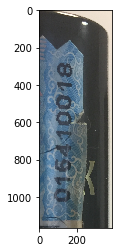

In [81]:
%%time

excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

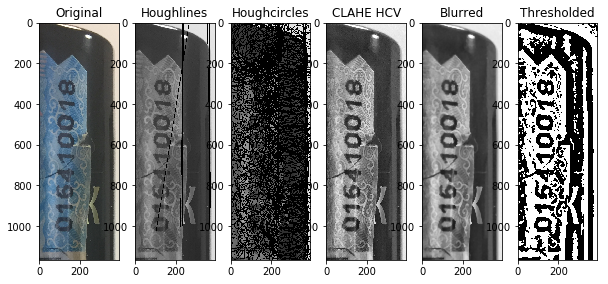

In [46]:
def binarize():
    fig = plt.figure(figsize=(10, 150))

    # resized = imutils.resize(cropped, height=500)
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    
    a = fig.add_subplot(1, 6, 1)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Original')
    
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    lines = cv2.HoughLines(edges,1,np.pi/180,200)
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(gray,(x1,y1),(x2,y2),(0,0,255),2)
        
    a = fig.add_subplot(1, 6, 2)
    imgplot = plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
    a.set_title('Houghlines')
    
    circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(gray,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(gray,(i[0],i[1]),2,(0,0,255),3)
    
    a = fig.add_subplot(1, 6, 3)
    imgplot = plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
    a.set_title('Houghcircles')
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hsv_image = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    
    a = fig.add_subplot(1, 6, 4)
    imgplot = plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE HCV')

    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)

    a = fig.add_subplot(1, 6, 5)
    imgplot = plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred')

    # resized = imutils.resize(blurred, height=500)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    a = fig.add_subplot(1, 6, 6)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded')

    plt.show()
    
# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import time
# help on convolve2d: http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

def Kuwahara(original, winsize):

    image = original.astype(np.float64)
    # make sure window size is correct
    if winsize%4 != 1:
        raise Exception ("Invalid winsize %s: winsize must follow formula: w = 4*n+1." %winsize)

    #Build subwindows
    tmpAvgKerRow = np.hstack((np.ones((1, (int)((winsize-1)/2+1))),np.zeros((1, (int)((winsize-1)/2)))))
    tmpPadder = np.zeros((1,winsize))
    tmpavgker = np.tile(tmpAvgKerRow, ((int)((winsize-1)/2+1),1))
    tmpavgker = np.vstack((tmpavgker, np.tile(tmpPadder, ((int)((winsize-1)/2),1))))
    tmpavgker = tmpavgker/np.sum(tmpavgker)

    # tmpavgker is a 'north-west' subwindow (marked as 'a' above)
    # we build a vector of convolution kernels for computing average and
    # variance
    avgker = np.empty((4,winsize,winsize)) # make an empty vector of arrays
    avgker[0] = tmpavgker			# North-west (a)
    avgker[1] = np.fliplr(tmpavgker)	# North-east (b)
    avgker[2] = np.flipud(tmpavgker)	# South-west (c)
    avgker[3] = np.fliplr(avgker[2])	# South-east (d)
    
    # Create a pixel-by-pixel square of the image
    squaredImg = image**2
    
    # preallocate these arrays to make it apparently %15 faster
    avgs = np.zeros([4, image.shape[0],image.shape[1]])
    stddevs = avgs.copy()

    # Calculation of averages and variances on subwindows
    for k in range(4):
        avgs[k] = convolve2d(image, avgker[k],mode='same') 	    # mean on subwindow
    stddevs[k] = convolve2d(squaredImg, avgker[k],mode='same')  # mean of squares on subwindow
    stddevs[k] = stddevs[k]-avgs[k]**2 			    # variance on subwindow
    
    # Choice of index with minimum variance
    indices = np.argmin(stddevs,0) # returns index of subwindow with smallest variance

    # Building the filtered image (with nested for loops)
    filtered = np.zeros(original.shape)
    for row in range(original.shape[0]):
        for col in range(original.shape[1]):
            filtered[row,col] = avgs[indices[row,col], row,col]

    #filtered=filtered.astype(np.uint8)
    return filtered.astype(np.uint8)

CPU times: user 363 ms, sys: 145 µs, total: 363 ms
Wall time: 363 ms


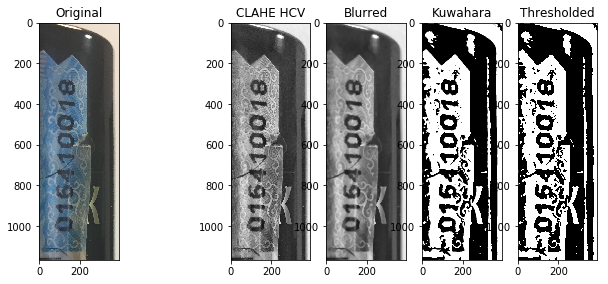

In [59]:
def binarize():
    fig = plt.figure(figsize=(10, 150))
   
    a = fig.add_subplot(1, 6, 1)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Original')
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hsv_image = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    
    a = fig.add_subplot(1, 6, 3)
    imgplot = plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE HCV')

    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)

    a = fig.add_subplot(1, 6, 4)
    imgplot = plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred')

    # resized = imutils.resize(blurred, height=500)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 1)
    kuwahara = Kuwahara(thresholded, 5)
    %time kuwahara = Kuwahara(kuwahara , 5)
    
    a = fig.add_subplot(1, 6, 5)
    imgplot = plt.imshow(cv2.cvtColor(kuwahara, cv2.COLOR_GRAY2RGB))
    a.set_title('Kuwahara')
    
    a = fig.add_subplot(1, 6, 6)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded')

    plt.show()
    
# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

In [57]:
def build_segmentation_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_GRAY2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_GRAY2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')
    
def build_contoured_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_BGR2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')

CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 79.7 ms


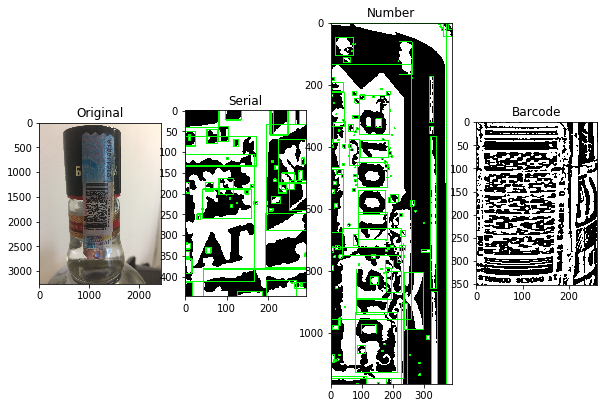

In [27]:
def excise_segmentation(image):
    
    number = image[78:78+1166, 1276:1276+392]
    serial = image[2088:2088+448, 1276:1276+292]
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Serial
    hsv_image = cv2.cvtColor(serial, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    serial_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 1)
    
    edged = cv2.Canny(serial_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    serial_contours = np.dstack([serial_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(serial_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Number
    hsv_image = cv2.cvtColor(number, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    number_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 1)
    
    edged = cv2.Canny(number_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    number_contours = np.dstack([number_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(number_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Barcode
    barcode_thresholded = image[880:880+1408, 828:828+868]
    barcode = imutils.resize(image[880:880+1408, 828:828+868], height=500)
    hsv_image = cv2.cvtColor(barcode, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    gray = clahe.apply(v)
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.medianBlur(gradient, 11)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morph = cv2.erode(closed, None, iterations = 11)
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    if len(cnts):
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        (x, y, w, h) = cv2.boundingRect(c)
        # PDF417 correction
        x = x - 10 if (x > 10) else 0
        w = w + 20 if (w < 868 - x - 20) else 868 - x
        # Top and bottom black line in PDF417
        y = y - (int)(0.3 * h) if (y > 0.3 * h) else 0
        h = h + (int)(0.5 * h) if (h < 1408 - y - (int)(0.6 * h)) else 1408 - y        
        hsv_image = cv2.cvtColor(barcode[y:y+h, x:x+w], cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        gray = clahe.apply(v)
        blured = cv2.medianBlur(gray, 3)
        barcode_thresholded = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 1)        
 
    # return the segmentationed images
    # return serial_thresholded, number_thresholded, barcode_thresholded
    return serial_contours, number_contours, barcode_thresholded
    # return serial_thresholded, number_contours, barcode_thresholded

# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
filescount = 1
current_file_index = 0
fig = plt.figure(figsize=(10, 200))
%time serial_thresholded, number_thresholded, barcode_thresholded = excise_segmentation(excise_src)

# build_segmentation_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)
build_contoured_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)

plt.show()

# Try Skeletonize

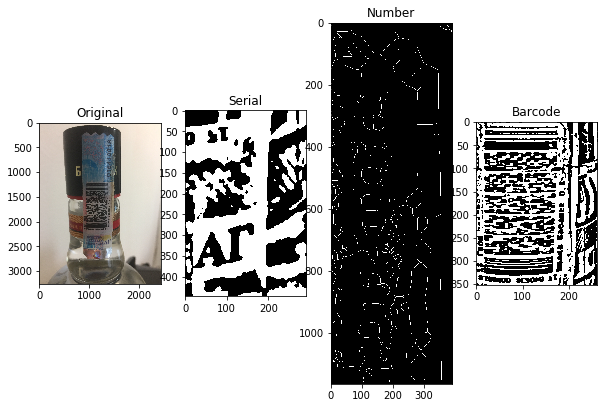

In [63]:
def excise_segmentation(image):
    
    number = image.copy()[78:78+1166, 1276:1276+392]
    serial = image.copy()[2088:2088+448, 1276:1276+292]
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Serial
    hsv_image = cv2.cvtColor(serial, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    serial_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 1)
    
    edged = cv2.Canny(serial_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    serial_contours = np.dstack([serial_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(serial_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Number
    hsv_image = cv2.cvtColor(number, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    number_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 1)
    
    # Binarize
    number_thresholded_canny = number_thresholded.copy()
    number_thresholded = invert(number_thresholded)
    number_thresholded[number_thresholded == 255] = 1
    number_thresholded = np.array(255 * skeletonize(number_thresholded), dtype = np.uint8)
    
    edged = cv2.Canny(number_thresholded_canny, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    number_contours = np.dstack([number_thresholded_canny.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(number_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Barcode
    barcode_thresholded = image.copy()[880:880+1408, 828:828+868]
    barcode = imutils.resize(image.copy()[880:880+1408, 828:828+868], height=500)
    hsv_image = cv2.cvtColor(barcode, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    gray = clahe.apply(v)
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.medianBlur(gradient, 11)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morph = cv2.erode(closed, None, iterations = 11)
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    if len(cnts):
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        (x, y, w, h) = cv2.boundingRect(c)
        # PDF417 correction
        x = x - 10 if (x > 10) else 0
        w = w + 20 if (w < 868 - x - 20) else 868 - x
        # Top and bottom black line in PDF417
        y = y - (int)(0.3 * h) if (y > 0.3 * h) else 0
        h = h + (int)(0.5 * h) if (h < 1408 - y - (int)(0.6 * h)) else 1408 - y        
        hsv_image = cv2.cvtColor(barcode[y:y+h, x:x+w], cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        gray = clahe.apply(v)
        blured = cv2.medianBlur(gray, 3)
        barcode_thresholded = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 1)  
    
    # return the segmentationed images
    return serial_thresholded, number_thresholded, barcode_thresholded
    # return serial_contours, number_contours, barcode_thresholded
    # return serial_thresholded, number_contours, barcode_thresholded

# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
filescount = 1
current_file_index = 0
fig = plt.figure(figsize=(10, 200))
serial_thresholded, number_thresholded, barcode_thresholded = excise_segmentation(excise_src)

build_segmentation_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)
# build_contoured_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)

plt.show()

## Still fail